In [1]:
%matplotlib widget
from ipywidgets import *
from functools import lru_cache
import numpy as np
import scipy as sp
import scipy.integrate as spi
import sympy as sym
import matplotlib.pyplot as plt

sym.init_printing(use_unicode=True)

resolution = 50
phi = sym.Symbol("phi")
phi_v = (1 + sym.sqrt(5))/ 2

# The $\Phi$top

Sold a as kind of "executive toy" the $\Phi$top is a metal "egg" which draws fascination as when spun about its major axis, above a certain speed, the egg "magically" stands up on end in apparent defiance of gravity. The effect can be seen in the first few seconds of [this video](https://www.youtube.com/watch?v=hLuqb_rKenI). This discussion aims to explain why gravity is not being defied, and the behaviour of this "egg" is entirely consistent with the laws of physics as they are currently understood.

We shall initially consider how to represent the body of the $\Phi$top and how to represent its transition from resting with its major axis parallel to the ground plane, to its minor axes being parallel. We shall then look at the rotational kinetic energy of the $\Phi$top, and in order to do that will will need to calculate its moment of inertia about the z-axis. To complete the Lagrangian we shall look at the potential energy, whish is independent of the rotational velocity, and then finally construct the Lagrangian which will reveal the observed behaviour.

## Representation

The $\Phi$top is a prolate spheroid with a ratio of minor axis to major axis of $\phi$ (the golden ratio). The traditional form of a spheroid (being an elipsoid with two axes of equal length) is:

$$\frac{x^2 + y^2}{a^2} + \frac{z^2}{c^2} = 0$$

Our problem requires us to consider how this shape rotates, so a parametric vector form will be more useful so that we can use matrices to express the rotation. We'll use $\alpha$ and $\beta$ as spherical parameters.

$$
\begin{pmatrix}
a\cos\alpha \\
c\sin\alpha\sin\beta \\
c\sin\alpha\cos\beta
\end{pmatrix}
\begin{cases}
0 \leq \alpha \leq \pi \\
-\pi \leq \beta \leq \pi 
\end{cases}
$$

We know that the ratio of $a$ to $c$ must be $\phi$ so let's factor that in.

$$
\begin{pmatrix}
\phi\cos\alpha \\
\sin\alpha\sin\beta \\
\sin\alpha\cos\beta
\end{pmatrix}
\begin{cases}
0 \leq \alpha \leq \pi \\
-\pi \leq \beta \leq \pi 
\end{cases}
$$

Now multiply that by a rotation of $\theta$ about the y-axis:

$$
\begin{pmatrix}
\cos \theta & 0 & - \sin \theta \\
0 & 1 & 0 \\
\sin \theta & 0 & \cos \theta 
\end{pmatrix}
.
\begin{pmatrix}
\phi\cos\alpha \\
\sin\alpha\sin\beta \\
\sin\alpha\cos\beta
\end{pmatrix}
\begin{cases}
0 \leq \alpha \leq \pi \\
-\pi \leq \beta \leq \pi \\
0 \leq \theta \leq \frac{\pi}{2}
\end{cases}
$$

$$
\begin{pmatrix}
\phi \cos \theta \cos \alpha - \sin \theta \sin \alpha \cos \beta \\
\sin \alpha \sin \beta \\
\phi \sin \theta \cos \alpha + \cos \theta \sin \alpha \cos \beta
\end{pmatrix}
\begin{cases}
0 \leq \alpha \leq \pi \\
-\pi \leq \beta \leq \pi \\
0 \leq \theta \leq \frac{\pi}{2}
\end{cases}
$$

Implementing this in Python allows us to validate that we indeed can see prolate spheroid, and that as we vary $\theta$, the spheroid rotates about the $y$-axis.

In [2]:
def derive_phitop():

    alpha, beta = sym.symbols("alpha beta")

    def spheroid(a,c, alpha=alpha, beta=beta):
        """a general spheroid in three dimensions"""
        return sym.Matrix([a*sym.cos(alpha), c*sym.sin(alpha)*sym.sin(beta), c*sym.sin(alpha)*sym.cos(beta)])

    theta = sym.symbols("theta")

    def rotation(theta=theta):
        """a rotation about the y-axis"""
        return sym.Matrix([
            [sym.cos(theta), 0, -sym.sin(theta)],
            [0, 1, 0],
            [sym.sin(theta), 0, sym.cos(theta)]
        ])
    
    return rotation() * spheroid(phi,1)

phitop = derive_phitop()

interactive(children=(FloatSlider(value=0.0, description='theta', max=1.5707963267948966, step=0.01), FloatSli…

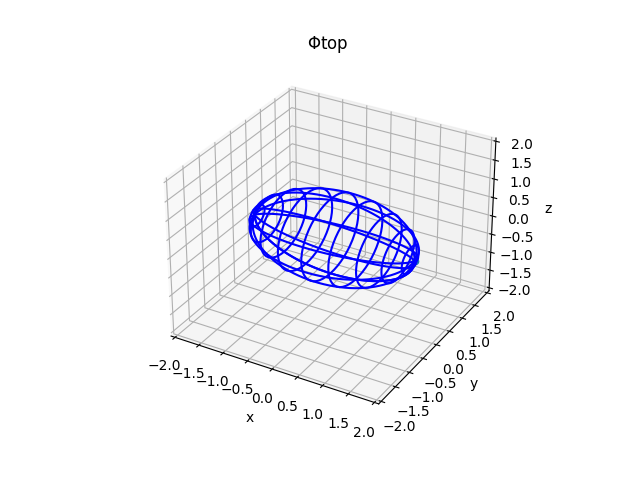

In [3]:
phitop_v = sym.lambdify([sym.Symbol("alpha"), sym.Symbol("beta"), sym.Symbol("theta")],phitop.subs({phi:phi_v}), 'numpy')
phitop_v

def plot_phitop(axes, theta):
    alphas, betas = np.meshgrid(np.linspace(0,np.pi,resolution),np.linspace(-np.pi,np.pi,resolution))
    data = phitop_v(alphas, betas, theta)
    return axes.plot_wireframe(data[0,0],data[1,0],data[2,0],color="b", rstride=5, cstride=5)

def display_phitop():
    phitop_plot = None
    point_plot = None
    fig = plt.figure()
    ax = fig.add_subplot(1,1,1, projection="3d")
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.set_zlabel("z")
    ax.set_xlim([-2,2])
    ax.set_ylim([-2,2])
    ax.set_zlim([-2,2])

    def update(theta = 0, alpha=0, beta=0):
        nonlocal phitop_plot, point_plot
        if phitop_plot:
            phitop_plot.remove()
            
        if point_plot:
            point_plot.remove()
            
        phitop_plot = plot_phitop(ax, theta)
        point = phitop_v(alpha,beta,theta)
        point_plot = ax.scatter(point[0], point[1], point[2])
        fig.canvas.draw_idle()

    plt.title(r'$\Phi$top')

    interact(update, alpha=(0,np.pi,0.01), beta=(-np.pi,np.pi,0.01), theta=(0,np.pi/2,0.01))
    
display_phitop()

## Rotational Kinetic Energy

Rotational Kinetic Energy is given by:

$$
\mathcal{T} = \frac{1}{2}I\omega^2
$$

where $I$ is the moment of inertia, and $\omega\$ is the rotational velocity. In order for us to consider the rotational kinetic energy, we must first consider the moment of inertia.

## Moment of Inertia

In [4]:
def derive_moment_of_inertia():
    x,z,y = sym.symbols("x y z")
    alpha, beta = sym.symbols("alpha beta")
    
    def moment_of_inertia_integrand():
        m = sym.Matrix([
            [y**2 + z**2, -x*y, -x*z],
            [-x*y, x**2 + z**2, -y*z],
            [-x*z, -y*z, x**2 + y**2]
        ])
        return m

    parametric_integrand = moment_of_inertia_integrand().subs({x: phitop[0], y: phitop[1], z:phitop[2]})
    
    moi_by_alpha = sym.Integral(parametric_integrand,(alpha,0,sym.pi)).doit()
    moi_by_beta = sym.Integral(moi_by_alpha,(beta,-sym.pi,sym.pi)).doit()
    return moi_by_beta
moment_of_inertia = derive_moment_of_inertia()[2,2]

From [Mathworld](https://scienceworld.wolfram.com/physics/MomentofInertia.html) we can see that the moment of inertia is defined by:

$$
I \equiv \int_V \rho \begin{bmatrix}
y^2 + z^2 & -xy & -xz \\
-xy & x^2 + z^2 & -yz \\
-xz & -yz & x^2 + y^2 
\end{bmatrix}dxdydz
$$

Given we have a constant density, which we shall assume to be 1, we can lose the $\rho$ term.

$$
I \equiv \int_V \begin{bmatrix}
y^2 + z^2 & -xy & -xz \\
-xy & x^2 + z^2 & -yz \\
-xz & -yz & x^2 + y^2 
\end{bmatrix}dxdydz
$$

Subsituting in our earlier values for $x$ and $y$ we get:

$$
I \equiv \int_{-\pi}^{\pi} \int_0^\pi \left[\begin{matrix}\left(\phi \sin{\left(\theta \right)} \cos{\left(\alpha \right)} + \sin{\left(\alpha \right)} \cos{\left(\beta \right)} \cos{\left(\theta \right)}\right)^{2} + \sin^{2}{\left(\alpha \right)} \sin^{2}{\left(\beta \right)} & - \left(\phi \cos{\left(\alpha \right)} \cos{\left(\theta \right)} - \sin{\left(\alpha \right)} \sin{\left(\theta \right)} \cos{\left(\beta \right)}\right) \sin{\left(\alpha \right)} \sin{\left(\beta \right)} & - \left(\phi \sin{\left(\theta \right)} \cos{\left(\alpha \right)} + \sin{\left(\alpha \right)} \cos{\left(\beta \right)} \cos{\left(\theta \right)}\right) \left(\phi \cos{\left(\alpha \right)} \cos{\left(\theta \right)} - \sin{\left(\alpha \right)} \sin{\left(\theta \right)} \cos{\left(\beta \right)}\right)\\- \left(\phi \cos{\left(\alpha \right)} \cos{\left(\theta \right)} - \sin{\left(\alpha \right)} \sin{\left(\theta \right)} \cos{\left(\beta \right)}\right) \sin{\left(\alpha \right)} \sin{\left(\beta \right)} & \left(\phi \sin{\left(\theta \right)} \cos{\left(\alpha \right)} + \sin{\left(\alpha \right)} \cos{\left(\beta \right)} \cos{\left(\theta \right)}\right)^{2} + \left(\phi \cos{\left(\alpha \right)} \cos{\left(\theta \right)} - \sin{\left(\alpha \right)} \sin{\left(\theta \right)} \cos{\left(\beta \right)}\right)^{2} & - \left(\phi \sin{\left(\theta \right)} \cos{\left(\alpha \right)} + \sin{\left(\alpha \right)} \cos{\left(\beta \right)} \cos{\left(\theta \right)}\right) \sin{\left(\alpha \right)} \sin{\left(\beta \right)}\\- \left(\phi \sin{\left(\theta \right)} \cos{\left(\alpha \right)} + \sin{\left(\alpha \right)} \cos{\left(\beta \right)} \cos{\left(\theta \right)}\right) \left(\phi \cos{\left(\alpha \right)} \cos{\left(\theta \right)} - \sin{\left(\alpha \right)} \sin{\left(\theta \right)} \cos{\left(\beta \right)}\right) & - \left(\phi \sin{\left(\theta \right)} \cos{\left(\alpha \right)} + \sin{\left(\alpha \right)} \cos{\left(\beta \right)} \cos{\left(\theta \right)}\right) \sin{\left(\alpha \right)} \sin{\left(\beta \right)} & \left(\phi \cos{\left(\alpha \right)} \cos{\left(\theta \right)} - \sin{\left(\alpha \right)} \sin{\left(\theta \right)} \cos{\left(\beta \right)}\right)^{2} + \sin^{2}{\left(\alpha \right)} \sin^{2}{\left(\beta \right)}\end{matrix}\right]d\alpha d\beta
$$

and evaluating:

$$
I = \left[\begin{matrix}\pi^{2} \phi^{2} \sin^{2}{\left(\theta \right)} + \frac{\pi^{2} \cos^{2}{\left(\theta \right)}}{2} + \frac{\pi^{2}}{2} & 0 & - \pi^{2} \phi^{2} \sin{\left(\theta \right)} \cos{\left(\theta \right)} + \frac{\pi^{2} \sin{\left(\theta \right)} \cos{\left(\theta \right)}}{2}\\0 & \pi^{2} \phi^{2} \sin^{2}{\left(\theta \right)} + \pi^{2} \phi^{2} \cos^{2}{\left(\theta \right)} + \frac{\pi^{2} \sin^{2}{\left(\theta \right)}}{2} + \frac{\pi^{2} \cos^{2}{\left(\theta \right)}}{2} & 0\\- \pi^{2} \phi^{2} \sin{\left(\theta \right)} \cos{\left(\theta \right)} + \frac{\pi^{2} \sin{\left(\theta \right)} \cos{\left(\theta \right)}}{2} & 0 & \pi^{2} \phi^{2} \cos^{2}{\left(\theta \right)} + \frac{\pi^{2} \sin^{2}{\left(\theta \right)}}{2} + \frac{\pi^{2}}{2}\end{matrix}\right]
$$

For this problem we will only be considering rotation about the positive $z$-axis, so we can take:

$$
I = \pi^{2} \phi^{2} \cos^{2}{\left(\theta \right)} + \frac{\pi^{2} \sin^{2}{\left(\theta \right)}}{2} + \frac{\pi^{2}}{2}
$$

interactive(children=(FloatSlider(value=0.0, description='theta', max=1.5707963267948966, step=0.01), Output()…

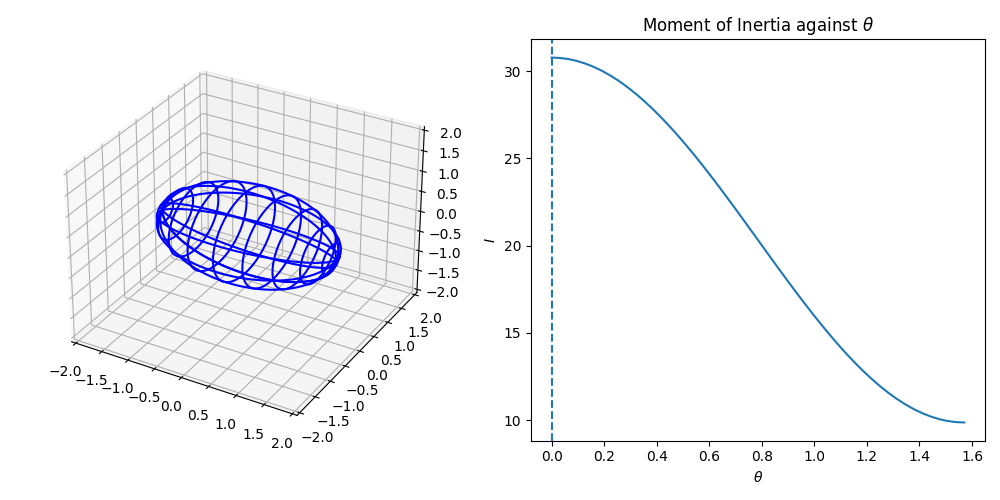

In [5]:
def plot_moi():
    _moment_of_inertia = sym.lambdify(sym.Symbol("theta"), moment_of_inertia.subs({phi:phi_v}), "numpy")
    
    alphas, betas = np.meshgrid(np.linspace(0,np.pi,50),np.linspace(-np.pi,np.pi,resolution))
    thetas = np.linspace(0,np.pi/2,resolution)
    mois = _moment_of_inertia(thetas)

    fig = plt.figure(figsize=[10, 5])
    ax = fig.add_subplot(1,2,1, projection="3d")
    ax.set_xlim([-2,2])
    ax.set_ylim([-2,2])
    ax.set_zlim([-2,2])
    bx = fig.add_subplot(1,2,2)
    bx.plot(thetas, mois)
    bx.set_xlabel(r"$\theta$")
    bx.set_ylabel("$I$")
    bx.set_title(r"Moment of Inertia against $\theta$")

    phitop_plot = None
    vline = None
    
    def update(theta = 0):
        nonlocal phitop_plot, vline
        if phitop_plot:
            phitop_plot.remove()
            
        if vline:
            vline.remove()
       
        phitop_plot = plot_phitop(ax, theta)
        vline = bx.axvline(x=theta, linestyle='--')
        fig.tight_layout()
        fig.canvas.draw_idle()

    interact(update, theta=(0,np.pi/2,0.01))
    
plot_moi()

## Rotational Kinetic Energy

We saw earlier that

$$
\mathcal{T} = \frac{1}{2}I\omega^2
$$

Subsituting in our value for $I$ we get:

$$
\mathcal{T} = \frac{1}{2}\left(\pi^{2} \phi^{2} \cos^{2}{\left(\theta \right)} + \frac{\pi^{2} \sin^{2}{\left(\theta \right)}}{2} + \frac{\pi^{2}}{2}\right)\omega^2
$$

In [6]:
def derive_rotational_kinetic_energy():
    omega = sym.Symbol("omega")
    return 0.5 * omega * omega * moment_of_inertia
rotational_kinetic_energy = derive_rotational_kinetic_energy()

## Potential Energy

In [7]:
def derive_potential_energy():
    theta = sym.symbols("theta")
    return phi / sym.sqrt(phi**2*sym.sin(sym.pi/2 - theta)**2 + sym.cos(sym.pi/2-theta)**2)
potential_energy = derive_potential_energy()

The potential energy of the spheroid is distance of the centre of mass (which is also the physical centre) to the lowest point on the egg for any $\theta$. This is simply the radius of the cross-sectional ellipse at the appropriate angle. In general, the radius of an ellipse at angle $\psi$ from the horizontal is given by:

$$
r = \frac{ab}{\sqrt{a^2\sin^2\psi + b^2\cos^2\psi}}
$$

so in our particular case, the angle from the horizontal is $\phi = \frac{\pi}{2} - \theta$, the major radius is $a = \phi$ and the minor axis is $b=1$. Therefore:

$$
\mathcal{V} = \frac{\phi}{\sqrt{\phi^2\cos^2\theta + \sin^2\theta}}
$$

## Lagrangian

In [8]:
def derive_lagrangian():
    return rotational_kinetic_energy - potential_energy
lagrangian = derive_lagrangian()

The lagrangian is given by the difference between the rotational kinetic energy $\mathcal{T}$ and the potential energy $\mathcal{V}$:

$$
\begin{align}
\mathcal{L} &= \mathcal{T} - \mathcal{V} \\
&= \frac{1}{2}\left(\pi^{2} \phi^{2} \cos^{2}{\left(\theta \right)} + \frac{\pi^{2} \sin^{2}{\left(\theta \right)}}{2} + \frac{\pi^{2}}{2}\right)\omega^2 - \frac{\phi}{\sqrt{\phi^2\cos^2\theta + \sin^2\theta}}
\end{align}
$$

Let us consider $\theta$ as a function of $\omega$ and solve the Euler-Lagrange equation in one dimension:

$$
\frac{\partial \mathcal{L}}{\partial \omega} - \frac{d}{dt}\frac{\partial \mathcal{L}}{\partial \dot{\omega}} = 0
$$

As $\dot{\omega}$ does not appear in $\mathcal{L}$, this term vanishes and we are left with:

$$
\frac{\partial \mathcal{L}}{\partial \omega} = 0
$$

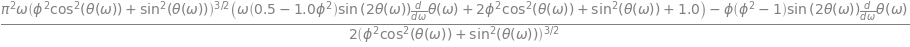

In [9]:
def derive_euler_lagrange():
    omega = sym.Symbol("omega")
    t = sym.Symbol("theta")
    theta = sym.Function("theta")(omega)
    return sym.diff(lagrangian.subs({t: theta}), omega)
derive_euler_lagrange().simplify()

euler_lagrange = derive_euler_lagrange().simplify()
euler_lagrange

In [ ]:
sym.dsolve()